##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models. This tutorial demonstrates:

1. How to use TensorFlow Hub with `tf.keras`.
1. How to do image classification using TensorFlow Hub.
1. How to do simple transfer learning.

## Setup

In [2]:
import matplotlib.pylab as plt

import tensorflow as tf

In [3]:
!pip install -q tensorflow-hub
!pip install -q tensorflow-datasets
import tensorflow_hub as hub

from tensorflow.keras import layers

## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer. Any [TensorFlow 2 compatible image classifier URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

 8192/61306 [===>..........................] - ETA: 0s

65536/61306 [================================] - 0s 0us/step


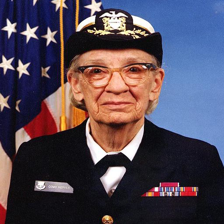

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

We have the predicted class ID,
Fetch the `ImageNet` labels, and decode the predictions

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

 8192/10484 [======================>.......] - ETA: 0s

16384/10484 [==============================================] - 0s 0us/step


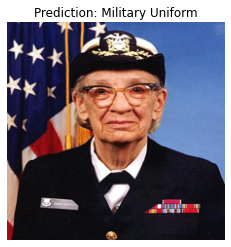

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [12]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

     8192/228813984 [..............................] - ETA: 3s

  8396800/228813984 [>.............................] - ETA: 11s

 16785408/228813984 [=>............................] - ETA: 6s 

 28893184/228813984 [==>...........................] - ETA: 3s

 41951232/228813984 [====>.........................] - ETA: 3s

 50339840/228813984 [=====>........................] - ETA: 3s

 62300160/228813984 [=======>......................] - ETA: 3s

 75505664/228813984 [========>.....................] - ETA: 3s

 83894272/228813984 [=========>....................] - ETA: 3s

 99024896/228813984 [===========>..................] - ETA: 2s

109060096/228813984 [=============>................] - ETA: 2s

117448704/228813984 [==============>...............] - ETA: 2s

129441792/228813984 [===============>..............] - ETA: 1s

142614528/228813984 [=================>............] - ETA: 1s

158130176/228813984 [===================>..........] - ETA: 1s

159670272/228813984 [===================>..........] - ETA: 1s

171835392/228813984 [=====================>........] - ETA: 0s

176168960/228813984 [======================>.......] - ETA: 0s

189644800/228813984 [=======================>......] - ETA: 0s

202973184/228813984 [=========================>....] - ETA: 0s

209723392/228813984 [==========================>...] - ETA: 0s

224804864/228813984 [============================>.] - ETA: 0s

228818944/228813984 [==============================] - 4s 0us/step


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [16]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pot', 'daisy', 'bonnet', 'daisy', 'daisy', 'vine snake', 'knot',
       'daisy', 'daisy', 'quill', 'honeycomb', 'daisy', 'sea urchin',
       'flamingo', 'ant', 'cardoon', 'daisy', 'admiral', 'daisy',
       'pencil sharpener', "yellow lady's slipper", 'maze', 'pot', 'bee',
       'coral fungus', 'daisy', 'cardoon', 'cardoon', 'daisy', 'rapeseed',
       'rapeseed', 'bee'], dtype='<U30')

Now check how these predictions line up with the images:

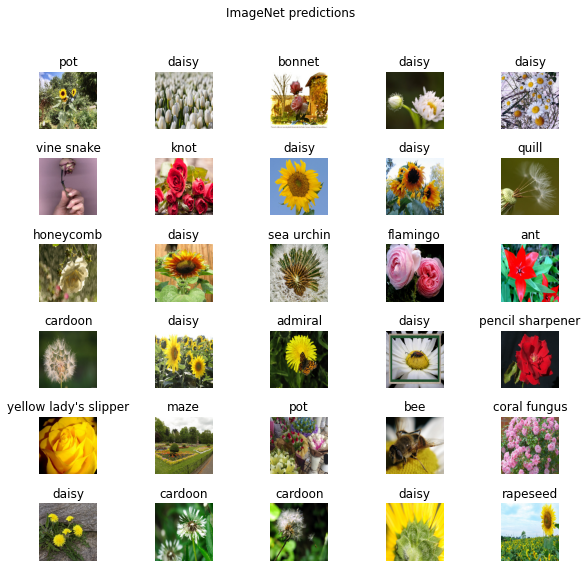

In [17]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [18]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the feature extractor.

In [19]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a 1280-length vector for each image:

In [20]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [21]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [22]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use compile to configure the training process:

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [26]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [27]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/2


  1/115 [..............................] - ETA: 0s - loss: 2.2101 - acc: 0.2188

  2/115 [..............................] - ETA: 5s - loss: 1.6832 - acc: 0.2188

  3/115 [..............................] - ETA: 8s - loss: 1.8071 - acc: 0.1875

  4/115 [>.............................] - ETA: 9s - loss: 1.5327 - acc: 0.2188

  5/115 [>.............................] - ETA: 9s - loss: 1.3807 - acc: 0.3750

  6/115 [>.............................] - ETA: 9s - loss: 1.3639 - acc: 0.4688

  7/115 [>.............................] - ETA: 9s - loss: 1.4767 - acc: 0.4688

  8/115 [=>............................] - ETA: 9s - loss: 1.5095 - acc: 0.3750

  9/115 [=>............................] - ETA: 9s - loss: 1.3143 - acc: 0.4062

 10/115 [=>............................] - ETA: 9s - loss: 1.3872 - acc: 0.5000

 11/115 [=>............................] - ETA: 9s - loss: 1.0729 - acc: 0.5625

 12/115 [==>...........................] - ETA: 9s - loss: 0.9913 - acc: 0.5938

 13/115 [==>...........................] - ETA: 9s - loss: 0.9019 - acc: 0.7500

 14/115 [==>...........................] - ETA: 9s - loss: 0.9939 - acc: 0.5938

 15/115 [==>...........................] - ETA: 8s - loss: 1.0228 - acc: 0.6562

 16/115 [===>..........................] - ETA: 8s - loss: 0.8732 - acc: 0.6875

 17/115 [===>..........................] - ETA: 8s - loss: 0.8224 - acc: 0.8125

 18/115 [===>..........................] - ETA: 8s - loss: 1.3666 - acc: 0.5938

 19/115 [===>..........................] - ETA: 8s - loss: 1.1628 - acc: 0.5938

 20/115 [====>.........................] - ETA: 8s - loss: 0.9493 - acc: 0.6562

 21/115 [====>.........................] - ETA: 8s - loss: 0.8789 - acc: 0.7188

 22/115 [====>.........................] - ETA: 8s - loss: 0.9372 - acc: 0.7188

 23/115 [=====>........................] - ETA: 8s - loss: 0.8896 - acc: 0.7188

 24/115 [=====>........................] - ETA: 8s - loss: 0.9489 - acc: 0.6250

 25/115 [=====>........................] - ETA: 8s - loss: 0.8299 - acc: 0.6875

 26/115 [=====>........................] - ETA: 7s - loss: 0.8192 - acc: 0.8125

 27/115 [======>.......................] - ETA: 7s - loss: 0.8196 - acc: 0.7188

 28/115 [======>.......................] - ETA: 7s - loss: 0.7828 - acc: 0.7500

 29/115 [======>.......................] - ETA: 7s - loss: 0.6302 - acc: 0.7812

 30/115 [======>.......................] - ETA: 7s - loss: 0.7461 - acc: 0.7812

 31/115 [=======>......................] - ETA: 7s - loss: 0.7543 - acc: 0.8125

 32/115 [=======>......................] - ETA: 7s - loss: 0.5477 - acc: 0.8125

 33/115 [=======>......................] - ETA: 7s - loss: 0.7082 - acc: 0.8125

 34/115 [=======>......................] - ETA: 7s - loss: 0.6465 - acc: 0.7500

 35/115 [========>.....................] - ETA: 7s - loss: 0.7806 - acc: 0.7188

 36/115 [========>.....................] - ETA: 7s - loss: 0.8916 - acc: 0.5625

 37/115 [========>.....................] - ETA: 6s - loss: 0.6948 - acc: 0.7188

 38/115 [========>.....................] - ETA: 6s - loss: 0.7178 - acc: 0.7812

 39/115 [=========>....................] - ETA: 6s - loss: 0.5863 - acc: 0.8125

 40/115 [=========>....................] - ETA: 6s - loss: 0.7003 - acc: 0.7500

 41/115 [=========>....................] - ETA: 6s - loss: 0.6050 - acc: 0.7812

 42/115 [=========>....................] - ETA: 6s - loss: 0.4160 - acc: 0.8438

 43/115 [==========>...................] - ETA: 6s - loss: 0.8482 - acc: 0.7188

 44/115 [==========>...................] - ETA: 6s - loss: 0.4206 - acc: 0.8750

 45/115 [==========>...................] - ETA: 6s - loss: 0.6498 - acc: 0.7188

 46/115 [===========>..................] - ETA: 6s - loss: 0.5166 - acc: 0.8438

 47/115 [===========>..................] - ETA: 6s - loss: 0.8007 - acc: 0.6875

 48/115 [===========>..................] - ETA: 5s - loss: 0.6299 - acc: 0.7188

 49/115 [===========>..................] - ETA: 5s - loss: 0.5316 - acc: 0.7812

 50/115 [============>.................] - ETA: 5s - loss: 0.5905 - acc: 0.8438

 51/115 [============>.................] - ETA: 5s - loss: 0.4791 - acc: 0.8125

 52/115 [============>.................] - ETA: 5s - loss: 0.6104 - acc: 0.8125

 53/115 [============>.................] - ETA: 5s - loss: 0.3615 - acc: 0.8438

 54/115 [=============>................] - ETA: 5s - loss: 0.5261 - acc: 0.8125

 55/115 [=============>................] - ETA: 5s - loss: 0.3495 - acc: 0.9375

 56/115 [=============>................] - ETA: 5s - loss: 0.4053 - acc: 0.8750

 57/115 [=============>................] - ETA: 5s - loss: 0.7644 - acc: 0.7188

 58/115 [==============>...............] - ETA: 5s - loss: 0.6404 - acc: 0.6875

 59/115 [==============>...............] - ETA: 4s - loss: 0.5943 - acc: 0.8750

 60/115 [==============>...............] - ETA: 4s - loss: 0.4391 - acc: 0.8750

 61/115 [==============>...............] - ETA: 4s - loss: 0.5933 - acc: 0.7188

 62/115 [===============>..............] - ETA: 4s - loss: 0.5537 - acc: 0.8125

 63/115 [===============>..............] - ETA: 4s - loss: 0.5485 - acc: 0.8438

 64/115 [===============>..............] - ETA: 4s - loss: 0.7577 - acc: 0.6875

 65/115 [===============>..............] - ETA: 4s - loss: 0.5382 - acc: 0.7812

 66/115 [================>.............] - ETA: 4s - loss: 0.4510 - acc: 0.8438

 67/115 [================>.............] - ETA: 4s - loss: 0.3917 - acc: 0.8438

 68/115 [================>.............] - ETA: 4s - loss: 0.4074 - acc: 0.9062

 69/115 [=================>............] - ETA: 4s - loss: 0.5211 - acc: 0.7812

 70/115 [=================>............] - ETA: 4s - loss: 0.5071 - acc: 0.8125

 71/115 [=================>............] - ETA: 3s - loss: 0.5891 - acc: 0.8125

 72/115 [=================>............] - ETA: 3s - loss: 0.3442 - acc: 0.9062

 73/115 [==================>...........] - ETA: 3s - loss: 0.2778 - acc: 0.9688

 74/115 [==================>...........] - ETA: 3s - loss: 0.3348 - acc: 0.8438

 75/115 [==================>...........] - ETA: 3s - loss: 0.4640 - acc: 0.8125

 76/115 [==================>...........] - ETA: 3s - loss: 0.2632 - acc: 0.9375

 77/115 [===================>..........] - ETA: 3s - loss: 0.3896 - acc: 0.8438

 78/115 [===================>..........] - ETA: 3s - loss: 0.2729 - acc: 0.9688

 79/115 [===================>..........] - ETA: 3s - loss: 0.7122 - acc: 0.7812

 80/115 [===================>..........] - ETA: 3s - loss: 0.4118 - acc: 0.8750

 81/115 [====================>.........] - ETA: 3s - loss: 0.4287 - acc: 0.8438

 82/115 [====================>.........] - ETA: 2s - loss: 0.4224 - acc: 0.8125

 83/115 [====================>.........] - ETA: 2s - loss: 0.7592 - acc: 0.7188

 84/115 [====================>.........] - ETA: 2s - loss: 0.3962 - acc: 0.9062

 85/115 [=====================>........] - ETA: 2s - loss: 0.3940 - acc: 0.8750

 86/115 [=====================>........] - ETA: 2s - loss: 0.5774 - acc: 0.7812

 87/115 [=====================>........] - ETA: 2s - loss: 0.5091 - acc: 0.7500

 88/115 [=====================>........] - ETA: 2s - loss: 0.3275 - acc: 0.9062

 89/115 [======================>.......] - ETA: 2s - loss: 0.6765 - acc: 0.7188

 90/115 [======================>.......] - ETA: 2s - loss: 0.3947 - acc: 0.8438

 91/115 [======================>.......] - ETA: 2s - loss: 0.3841 - acc: 0.8750

 92/115 [=======================>......] - ETA: 2s - loss: 0.3954 - acc: 0.8438

 93/115 [=======================>......] - ETA: 1s - loss: 0.5671 - acc: 0.8750

 94/115 [=======================>......] - ETA: 1s - loss: 0.4813 - acc: 0.8438

 95/115 [=======================>......] - ETA: 1s - loss: 0.5219 - acc: 0.7812

 96/115 [========================>.....] - ETA: 1s - loss: 0.5008 - acc: 0.8125

 97/115 [========================>.....] - ETA: 1s - loss: 0.2548 - acc: 0.9062

 98/115 [========================>.....] - ETA: 1s - loss: 0.6587 - acc: 0.7812

 99/115 [========================>.....] - ETA: 1s - loss: 0.6405 - acc: 0.7273

101/115 [=========================>....] - ETA: 1s - loss: 0.3722 - acc: 0.9062

102/115 [=========================>....] - ETA: 1s - loss: 0.3270 - acc: 0.9375

103/115 [=========================>....] - ETA: 1s - loss: 0.3216 - acc: 0.9062

104/115 [==========================>...] - ETA: 0s - loss: 0.3558 - acc: 0.9375

105/115 [==========================>...] - ETA: 0s - loss: 0.3930 - acc: 0.8438

106/115 [==========================>...] - ETA: 0s - loss: 0.4948 - acc: 0.8750

107/115 [==========================>...] - ETA: 0s - loss: 0.5962 - acc: 0.8125

108/115 [===========================>..] - ETA: 0s - loss: 0.3257 - acc: 0.9062

109/115 [===========================>..] - ETA: 0s - loss: 0.5321 - acc: 0.8438

110/115 [===========================>..] - ETA: 0s - loss: 0.3623 - acc: 0.9062

111/115 [===========================>..] - ETA: 0s - loss: 0.4667 - acc: 0.7812

112/115 [============================>.] - ETA: 0s - loss: 0.4483 - acc: 0.8750

113/115 [============================>.] - ETA: 0s - loss: 0.3170 - acc: 0.9062

114/115 [============================>.] - ETA: 0s - loss: 0.2322 - acc: 0.9375

115/115 [==============================] - ETA: 0s - loss: 0.4513 - acc: 0.8438

115/115 [==============================] - 10s 88ms/step - loss: 0.4513 - acc: 0.8438


Epoch 2/2


  1/115 [..............................] - ETA: 0s - loss: 0.5549 - acc: 0.8125

  2/115 [..............................] - ETA: 4s - loss: 0.6011 - acc: 0.7812

  3/115 [..............................] - ETA: 6s - loss: 0.3092 - acc: 0.9062

  4/115 [>.............................] - ETA: 7s - loss: 0.3992 - acc: 0.8750

  5/115 [>.............................] - ETA: 7s - loss: 0.3078 - acc: 0.9062

  6/115 [>.............................] - ETA: 7s - loss: 0.4408 - acc: 0.8750

  7/115 [>.............................] - ETA: 7s - loss: 0.3071 - acc: 0.8438

  8/115 [=>............................] - ETA: 8s - loss: 0.2545 - acc: 0.9375

  9/115 [=>............................] - ETA: 8s - loss: 0.4268 - acc: 0.8438

 10/115 [=>............................] - ETA: 8s - loss: 0.5791 - acc: 0.8125

 11/115 [=>............................] - ETA: 8s - loss: 0.3145 - acc: 0.8750

 12/115 [==>...........................] - ETA: 8s - loss: 0.2902 - acc: 0.9062

 13/115 [==>...........................] - ETA: 8s - loss: 0.3054 - acc: 0.8750

 14/115 [==>...........................] - ETA: 7s - loss: 0.3011 - acc: 0.9062

 15/115 [==>...........................] - ETA: 7s - loss: 0.3148 - acc: 0.8750

 16/115 [===>..........................] - ETA: 7s - loss: 0.2823 - acc: 0.9375

 17/115 [===>..........................] - ETA: 7s - loss: 0.3777 - acc: 0.8438

 18/115 [===>..........................] - ETA: 7s - loss: 0.3881 - acc: 0.8750

 19/115 [===>..........................] - ETA: 7s - loss: 0.2278 - acc: 0.9688

 20/115 [====>.........................] - ETA: 7s - loss: 0.4207 - acc: 0.8438

 21/115 [====>.........................] - ETA: 7s - loss: 0.4353 - acc: 0.8438

 22/115 [====>.........................] - ETA: 7s - loss: 0.3511 - acc: 0.8750

 23/115 [=====>........................] - ETA: 7s - loss: 0.2205 - acc: 0.9375

 24/115 [=====>........................] - ETA: 7s - loss: 0.3485 - acc: 0.8125

 25/115 [=====>........................] - ETA: 7s - loss: 0.4039 - acc: 0.8750

 26/115 [=====>........................] - ETA: 7s - loss: 0.3681 - acc: 0.8438

 27/115 [======>.......................] - ETA: 7s - loss: 0.2190 - acc: 0.9688

 28/115 [======>.......................] - ETA: 7s - loss: 0.2226 - acc: 0.9688

 29/115 [======>.......................] - ETA: 7s - loss: 0.2940 - acc: 0.9375

 30/115 [======>.......................] - ETA: 7s - loss: 0.2220 - acc: 0.9688

 31/115 [=======>......................] - ETA: 6s - loss: 0.5325 - acc: 0.8125

 32/115 [=======>......................] - ETA: 6s - loss: 0.2955 - acc: 0.8750

 33/115 [=======>......................] - ETA: 6s - loss: 0.3878 - acc: 0.8750

 34/115 [=======>......................] - ETA: 6s - loss: 0.4931 - acc: 0.7500

 35/115 [========>.....................] - ETA: 6s - loss: 0.4928 - acc: 0.8438

 36/115 [========>.....................] - ETA: 6s - loss: 0.5131 - acc: 0.6875

 37/115 [========>.....................] - ETA: 6s - loss: 0.1984 - acc: 1.0000

 38/115 [========>.....................] - ETA: 6s - loss: 0.2855 - acc: 0.9375

 39/115 [=========>....................] - ETA: 6s - loss: 0.3197 - acc: 0.9062

 40/115 [=========>....................] - ETA: 6s - loss: 0.3399 - acc: 0.8750

 41/115 [=========>....................] - ETA: 6s - loss: 0.2749 - acc: 0.9062

 42/115 [=========>....................] - ETA: 6s - loss: 0.5237 - acc: 0.7500

 43/115 [==========>...................] - ETA: 6s - loss: 0.2490 - acc: 0.9375

 44/115 [==========>...................] - ETA: 6s - loss: 0.2072 - acc: 0.9062

 45/115 [==========>...................] - ETA: 5s - loss: 0.4970 - acc: 0.9062

 46/115 [===========>..................] - ETA: 5s - loss: 0.3502 - acc: 0.8438

 47/115 [===========>..................] - ETA: 5s - loss: 0.2491 - acc: 0.9062

 48/115 [===========>..................] - ETA: 5s - loss: 0.3449 - acc: 0.8750

 49/115 [===========>..................] - ETA: 5s - loss: 0.2265 - acc: 0.9375

 50/115 [============>.................] - ETA: 5s - loss: 0.3329 - acc: 0.9062

 51/115 [============>.................] - ETA: 5s - loss: 0.3430 - acc: 0.8750

 52/115 [============>.................] - ETA: 5s - loss: 0.3194 - acc: 0.9062

 53/115 [============>.................] - ETA: 5s - loss: 0.4103 - acc: 0.8438

 54/115 [=============>................] - ETA: 5s - loss: 0.3185 - acc: 0.8750

 55/115 [=============>................] - ETA: 5s - loss: 0.4133 - acc: 0.8750

 56/115 [=============>................] - ETA: 5s - loss: 0.3933 - acc: 0.8438

 57/115 [=============>................] - ETA: 4s - loss: 0.1965 - acc: 0.9375

 58/115 [==============>...............] - ETA: 4s - loss: 0.2359 - acc: 0.9375

 59/115 [==============>...............] - ETA: 4s - loss: 0.3417 - acc: 0.9062

 60/115 [==============>...............] - ETA: 4s - loss: 0.3931 - acc: 0.8750

 61/115 [==============>...............] - ETA: 4s - loss: 0.3922 - acc: 0.8750

 62/115 [===============>..............] - ETA: 4s - loss: 0.2870 - acc: 0.9062

 63/115 [===============>..............] - ETA: 4s - loss: 0.1467 - acc: 1.0000

 64/115 [===============>..............] - ETA: 4s - loss: 0.3418 - acc: 0.9062

 65/115 [===============>..............] - ETA: 4s - loss: 0.2377 - acc: 0.9688

 66/115 [================>.............] - ETA: 4s - loss: 0.5926 - acc: 0.7812

 67/115 [================>.............] - ETA: 4s - loss: 0.3798 - acc: 0.8438

 68/115 [================>.............] - ETA: 3s - loss: 0.2265 - acc: 0.9062

 69/115 [=================>............] - ETA: 3s - loss: 0.1848 - acc: 0.9375

 70/115 [=================>............] - ETA: 3s - loss: 0.2871 - acc: 0.9375

 71/115 [=================>............] - ETA: 3s - loss: 0.4104 - acc: 0.8438

 72/115 [=================>............] - ETA: 3s - loss: 0.5419 - acc: 0.8750

 73/115 [==================>...........] - ETA: 3s - loss: 0.4284 - acc: 0.9062

 74/115 [==================>...........] - ETA: 3s - loss: 0.3001 - acc: 0.9062

 75/115 [==================>...........] - ETA: 3s - loss: 0.3036 - acc: 0.9375

 76/115 [==================>...........] - ETA: 3s - loss: 0.3790 - acc: 0.8750

 77/115 [===================>..........] - ETA: 3s - loss: 0.1546 - acc: 0.9688

 78/115 [===================>..........] - ETA: 3s - loss: 0.3351 - acc: 0.9062

 79/115 [===================>..........] - ETA: 3s - loss: 0.3208 - acc: 0.8750

 80/115 [===================>..........] - ETA: 2s - loss: 0.4493 - acc: 0.7812

 81/115 [====================>.........] - ETA: 2s - loss: 0.5525 - acc: 0.8125

 82/115 [====================>.........] - ETA: 2s - loss: 0.4489 - acc: 0.8750

 83/115 [====================>.........] - ETA: 2s - loss: 0.4614 - acc: 0.8125

 84/115 [====================>.........] - ETA: 2s - loss: 0.3907 - acc: 0.8438

 85/115 [=====================>........] - ETA: 2s - loss: 0.2766 - acc: 0.9375

 86/115 [=====================>........] - ETA: 2s - loss: 0.3501 - acc: 0.8438

 87/115 [=====================>........] - ETA: 2s - loss: 0.3690 - acc: 0.7812

 88/115 [=====================>........] - ETA: 2s - loss: 0.3567 - acc: 0.8438

 89/115 [======================>.......] - ETA: 2s - loss: 0.2517 - acc: 0.9375

 90/115 [======================>.......] - ETA: 2s - loss: 0.3343 - acc: 0.9062

 91/115 [======================>.......] - ETA: 2s - loss: 0.2001 - acc: 0.9062

 92/115 [=======================>......] - ETA: 1s - loss: 0.3291 - acc: 0.9062

 93/115 [=======================>......] - ETA: 1s - loss: 0.2129 - acc: 0.9375

 94/115 [=======================>......] - ETA: 1s - loss: 0.2338 - acc: 0.9091

 95/115 [=======================>......] - ETA: 1s - loss: 0.3814 - acc: 0.8750

 96/115 [========================>.....] - ETA: 1s - loss: 0.3432 - acc: 0.8750

 97/115 [========================>.....] - ETA: 1s - loss: 0.1655 - acc: 1.0000

 98/115 [========================>.....] - ETA: 1s - loss: 0.2691 - acc: 0.8438

 99/115 [========================>.....] - ETA: 1s - loss: 0.2934 - acc: 0.8750

100/115 [=========================>....] - ETA: 1s - loss: 0.3962 - acc: 0.8438

101/115 [=========================>....] - ETA: 1s - loss: 0.1854 - acc: 0.9375

102/115 [=========================>....] - ETA: 1s - loss: 0.4918 - acc: 0.8438

103/115 [=========================>....] - ETA: 1s - loss: 0.1266 - acc: 0.9688

104/115 [==========================>...] - ETA: 0s - loss: 0.2276 - acc: 0.8750

105/115 [==========================>...] - ETA: 0s - loss: 0.3649 - acc: 0.8750

106/115 [==========================>...] - ETA: 0s - loss: 0.3097 - acc: 0.9062

107/115 [==========================>...] - ETA: 0s - loss: 0.2692 - acc: 0.9062

108/115 [===========================>..] - ETA: 0s - loss: 0.3810 - acc: 0.8750

109/115 [===========================>..] - ETA: 0s - loss: 0.3134 - acc: 0.8750

110/115 [===========================>..] - ETA: 0s - loss: 0.5810 - acc: 0.8125

111/115 [===========================>..] - ETA: 0s - loss: 0.2844 - acc: 0.9375

112/115 [============================>.] - ETA: 0s - loss: 0.3630 - acc: 0.8750

113/115 [============================>.] - ETA: 0s - loss: 0.2102 - acc: 0.9688

114/115 [============================>.] - ETA: 0s - loss: 0.2335 - acc: 0.9688

115/115 [==============================] - ETA: 0s - loss: 0.2838 - acc: 0.8125

115/115 [==============================] - 10s 86ms/step - loss: 0.2838 - acc: 0.8125


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

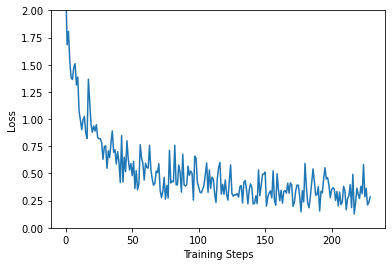

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

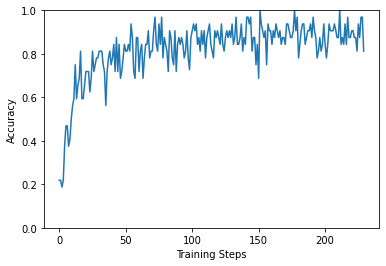

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [31]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [32]:
label_id = np.argmax(label_batch, axis=-1)

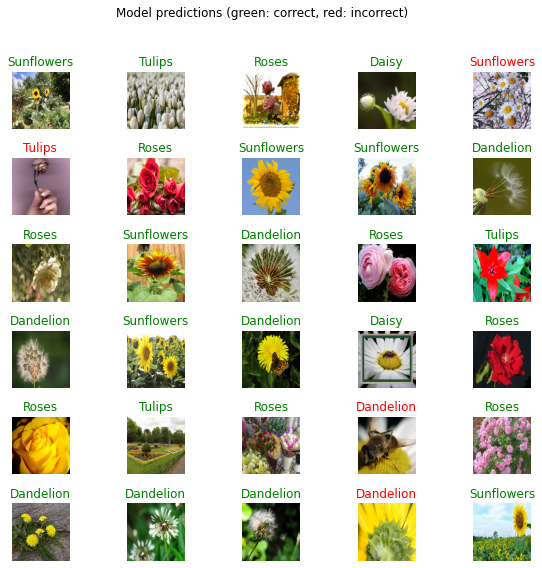

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

Now that you've trained the model, export it as a saved model:

In [34]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_models/1596504570/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1596504570/assets


'/tmp/saved_models/1596504570'

Now confirm that we can reload it, and it still gives the same results:

In [35]:
reloaded = tf.keras.models.load_model(export_path)

In [36]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [37]:
abs(reloaded_result_batch - result_batch).max()

0.0

This saved model can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).
